# Criando modelo de otimização

Nesse notebook, vamos criar um novo modelo agora trabalhando com as features do notebook `02_feat_engineering`. O algortimo escolhido para otimizar é a Random Forest por ser baseada em ensemble ela constrói diversas árvores de decisão "fracas" mas que quando visto seus resultados combinados acaba por gerar um modelo forte.

Para faciliar a leitura dessa parte, o código de construção do dataset se encontra em `src/data/make_dataset` e a de construção de features em `src/features/build_features`

In [1]:
import os 
## Change to root dir
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import yaml
import os 



from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score,f1_score,classification_report
from sklearn.feature_selection import RFECV

from typing import Union
from pathlib import Path
from helper import *
from src.features import *
from src.data.make_dataset import make_pipeline

/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 - Leitura dos dados

In [3]:
train_data = pd.read_csv("./data/processed/train_data.csv")
test_data = pd.read_csv("./data/processed/test_data.csv")

CAT_FEATS = train_data.select_dtypes(include="object",exclude=["int64","float64"]).columns.to_list()

train_data = convert_to_categoric(train_data,subset=CAT_FEATS)
test_data = convert_to_categoric(test_data,subset=CAT_FEATS)
train_data.dtypes

tipo_de_empresa                                                                    category
possui_mais_de_um_sócio                                                            category
funcionários                                                                       category
utiliza_serviços_financeiros                                                       category
possuicontador                                                                     category
faz_conciliação_bancária                                                           category
frequência_de_utilização_de_feature_do_sistema_módulo_financeiro                   category
frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal              category
frequência_de_utilização_de_feature_do_sistema_integração_bancária                 category
frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas                    category
frequência_de_utilização_de_feature_do_sistema_relatórios                       

## 2 - Aplicando feature engineering

Lembre-se do notebook `02_feat_engineering.ipynb` onde construimos novas features a partir de padrões encontrados nos dados, as funções que vão ser utilizadas aqui estão reunidas no script `build_features.py`.

In [4]:
list_funcs = [
    {
        "function":create_missing_indicator
    },
    {
        "function":count_class_frequency,
        "function_kwargs":{
            "class_to_count": "Uso frequente",
            "columns": [
                "frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
                "frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
                "frequência_de_utilização_de_feature_do_sistema_integração_bancária",
                "frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
                "frequência_de_utilização_de_feature_do_sistema_relatórios",
                "frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração"
            ]
        }
    },
    {
        "function":create_eq_or_gt_feature,
        "function_kwargs":{
            "feature_name":"is_receita_mensal_maior_ou_igual_70",
            "value":70.0,
            "columns":"receita_mensal"
        }
    }

]

In [5]:
train_data = make_pipeline(dataframe=train_data,functions=list_funcs)
test_data = make_pipeline(dataframe=test_data,functions=list_funcs)

In [6]:
# Verificando se temos as mesmas colunas em ambos os datasets
set(train_data.columns)==set(test_data.columns)

True

## 3 - Criando modelo não otimizado mas com as novas features 

Vamos aplicar inicialmente as novas features em um modelo simples de Random Forest sem procurar otimizar o modelo por enquanto

In [7]:
NUM_FEATURES = list(train_data.select_dtypes(include=["int64","float64"],exclude="category").columns)
CAT_FEATURES = list(train_data.select_dtypes(include=["category"],exclude=["int64","float64"]).columns)
TARGET = "churn"
NUM_FEATURES.remove(TARGET)

X_train = train_data[NUM_FEATURES+CAT_FEATURES]
y_train = train_data[TARGET]
X_test = test_data[NUM_FEATURES+CAT_FEATURES]
y_test = test_data[TARGET]

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))
print("y_train proporção de Churn e não churn:",y_train.value_counts(normalize=True))
print("y_test proporção de Churn e não churn:",y_test.value_counts(normalize=True))

X_train, y_train shape: ((5634, 25), (5634,))
X_test, y_test: ((1409, 25), (1409,))
y_train proporção de Churn e não churn: churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64
y_test proporção de Churn e não churn: churn
0    0.735273
1    0.264727
Name: proportion, dtype: float64


In [8]:
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES)])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', RandomForestClassifier(n_estimators=120,max_depth=5,class_weight='balanced'))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['emite_boletos',
                                                   'fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'qty_PoucoUso_features',
                                                   'is_possuicontador_null',
                                                   'is_receita_total_null',
                                                   'qty_usofrequente',
                                                   'is_receita_mensal_maior_ou_igual_70']),
                                                 ('cat', OneHotEncode...
                                                   'frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas',
                                                   'frequência_de_utilização_de_feature_do_sistema_relatórios',
                                                   'frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração',
                                                   'contrato',
                                                   'tipo_de_pagamento',
                                                   'clf_meses_permanência'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=120))])

In [9]:
y_pred_class_model1 = pipeline.predict(X_test)
y_pred_proba_model1 = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_class_model1,target_names=['non-churn', 'churn']))

              precision    recall  f1-score   support

   non-churn       0.93      0.73      0.82      1036
       churn       0.53      0.84      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



In [10]:
print("proporção de churn nos dados previstos:")
cat,ncat = np.unique(y_pred_class_model1,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

proporção de churn nos dados previstos:
0:0.5770049680624556
1:0.42299503193754434


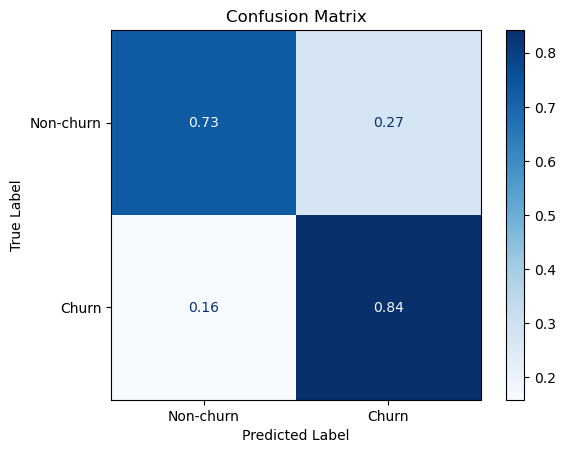

In [11]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class_model1, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Visualizando a confusion matrix e resultados do classification report, vemos que a Random Forest (RF) para esse problema conseguiu ser bem mais robusto que a Decision Tree. O modelo não otimizado conseguiu uma f1-score em 0.65 e recall de 0.84 é possível ter um balanço melhor ajustando hyperparametros da RF.

## 4 - Criando modelo otimizado

Vamos utilizar a bibloteca optuna para procurar os melhores hyperparametros da RF. 

In [16]:
def optimize_model(preprocessor:ColumnTransformer,
                   model:RandomForestClassifier,
                   num_trials:int,
                   n_splits:int,
                   params_func:callable,
                   X:Union[pd.DataFrame,np.array],
                   y:Union[pd.DataFrame,np.array])->optuna.study:
    def objective(trial):
        avg_roc = 0
        avg_f1 = 0
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for tr, ts in kf.split(X, y):
            Xtr, Xvl = X.iloc[tr], X.iloc[ts]
            ytr, yvl = y.iloc[tr], y.iloc[ts]
            
            params = params_func(trial)

            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model(**params))])
            pipe.fit(Xtr, ytr)

            yvl_pred_proba = pipe.predict_proba(Xvl)[:,1]

            avg_roc += roc_auc_score(yvl, yvl_pred_proba)
            avg_f1 += f1_score(yvl, yvl_pred_proba > 0.5, average='macro')

        print('avg roc:', avg_roc / n_splits)
        print('avg f1:', avg_f1 / n_splits)

        
        return avg_roc / n_splits
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective,n_trials=num_trials)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

    return study

def get_params(trial:optuna.trial)->dict:
    params = {
        "max_depth":trial.suggest_int("max_depth",2,8,log=True),
        "min_samples_split":trial.suggest_int("min_samples_split",2,5,log=True),
        "n_estimators":trial.suggest_int("n_estimators",150,220,log=True),
        "criterion":trial.suggest_categorical("criterion",["gini", "entropy", "log_loss"],),
        "class_weight":trial.suggest_categorical("class_weight",["balanced", "balanced_subsample"]),
        "random_state":82

    }
    return params

In [17]:
study = optimize_model(preprocessor=preprocessor,
                       model=RandomForestClassifier,
                       num_trials=20,
                       n_splits=5,
                       params_func=get_params,
                       X=X_train,
                       y=y_train)
best_params = study.best_params

[I 2024-03-20 21:34:48,055] A new study created in memory with name: no-name-558ed4bd-af28-4f93-b066-da7ab7752b18
[I 2024-03-20 21:34:50,675] Trial 0 finished with value: 0.828530970822225 and parameters: {'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 212, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.828530970822225.


avg roc: 0.828530970822225
avg f1: 0.6868361166886764


[I 2024-03-20 21:34:53,615] Trial 1 finished with value: 0.8331233450322797 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 159, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.8331233450322797.


avg roc: 0.8331233450322797
avg f1: 0.6980892287729157


[I 2024-03-20 21:34:59,809] Trial 2 finished with value: 0.8406695654832292 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 215, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8406695654832292.


avg roc: 0.8406695654832292
avg f1: 0.7161386097599304


[I 2024-03-20 21:35:02,411] Trial 3 finished with value: 0.8329956960780756 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 171, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8406695654832292.


avg roc: 0.8329956960780756
avg f1: 0.6978347278833847


[I 2024-03-20 21:35:04,638] Trial 4 finished with value: 0.8286686686673093 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 178, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8406695654832292.


avg roc: 0.8286686686673093
avg f1: 0.6871558069745868


[I 2024-03-20 21:35:09,126] Trial 5 finished with value: 0.8280778766141029 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 208, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8406695654832292.


avg roc: 0.8280778766141029
avg f1: 0.6868984494896186


[I 2024-03-20 21:35:14,249] Trial 6 finished with value: 0.8367363097645037 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 160, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8406695654832292.


avg roc: 0.8367363097645037
avg f1: 0.703301173594628


[I 2024-03-20 21:35:18,374] Trial 7 finished with value: 0.8408191693535484 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 155, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 7 with value: 0.8408191693535484.


avg roc: 0.8408191693535484
avg f1: 0.7256582415511222


[I 2024-03-20 21:35:23,888] Trial 8 finished with value: 0.8409788581495412 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 176, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8409788581495412
avg f1: 0.7176408391365099


[I 2024-03-20 21:35:30,091] Trial 9 finished with value: 0.8407634669929497 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 211, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8407634669929497
avg f1: 0.7166218851607004


[I 2024-03-20 21:35:33,962] Trial 10 finished with value: 0.8407087066044074 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 190, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8407087066044074
avg f1: 0.727649979928574


[I 2024-03-20 21:35:40,425] Trial 11 finished with value: 0.8407367715132716 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 151, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8407367715132716
avg f1: 0.7261820066317581


[I 2024-03-20 21:35:45,313] Trial 12 finished with value: 0.8387089702872942 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 191, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8387089702872942
avg f1: 0.7070524771895897


[I 2024-03-20 21:35:50,237] Trial 13 finished with value: 0.840853734057753 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 168, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.840853734057753
avg f1: 0.7178268155663436


[I 2024-03-20 21:35:55,257] Trial 14 finished with value: 0.8367085342588299 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 167, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8367085342588299
avg f1: 0.7027141331207125


[I 2024-03-20 21:35:59,740] Trial 15 finished with value: 0.8388299695593462 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 182, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8388299695593462
avg f1: 0.7075870094275063


[I 2024-03-20 21:36:04,547] Trial 16 finished with value: 0.8386942529452087 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 168, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8386942529452087
avg f1: 0.7083090747430209


[I 2024-03-20 21:36:11,216] Trial 17 finished with value: 0.8406131837846074 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 198, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8406131837846074
avg f1: 0.7160267526812657


[I 2024-03-20 21:36:13,715] Trial 18 finished with value: 0.8329725536239863 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 175, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8329725536239863
avg f1: 0.6977480517283382


[I 2024-03-20 21:36:18,607] Trial 19 finished with value: 0.8365965353058918 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 187, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.8409788581495412.


avg roc: 0.8365965353058918
avg f1: 0.7011952570181119
Number of finished trials: 20
Best trial: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 176, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}


In [18]:
# Define the pipeline for opt model
# Create the column transformer
preprocessor_for_bm = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES)
        ],
)

model_best_params = best_params
model_best_params["random_state"] = 82

# Define the pipeline
pipeline_for_bm = Pipeline(steps=[
    ('preprocessor', preprocessor_for_bm),  # Preprocessing (imputation + one-hot encoding)
    ('model', RandomForestClassifier(**model_best_params))  # Model
])

# Fit the pipeline to the training data
pipeline_for_bm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['emite_boletos',
                                                   'fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'qty_PoucoUso_features',
                                                   'is_possuicontador_null',
                                                   'is_receita_total_null',
                                                   'qty_usofrequente',
                                                   'is_receita_mensal_maior_ou_igual_70']),
                                                 ('cat', OneHotEncode...
                                                   'frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas',
                                                   'frequência_de_utilização_de_feature_do_sistema_relatórios',
                                                   'frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração',
                                                   'contrato',
                                                   'tipo_de_pagamento',
                                                   'clf_meses_permanência'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=6,
                                        n_estimators=176, random_state=82))])

Precision-Recall AUC: 0.6952979038777733
classification_report
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1036
           1       0.59      0.76      0.66       373

    accuracy                           0.80      1409
   macro avg       0.75      0.79      0.76      1409
weighted avg       0.82      0.80      0.80      1409


Best F1-score: 0.6658905704307334 at threshold 0.5654776370137015


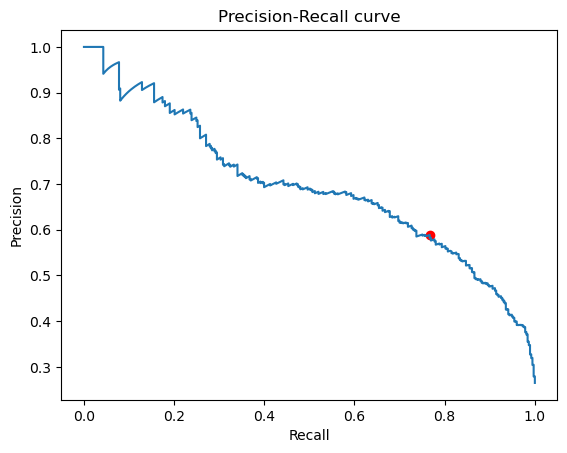

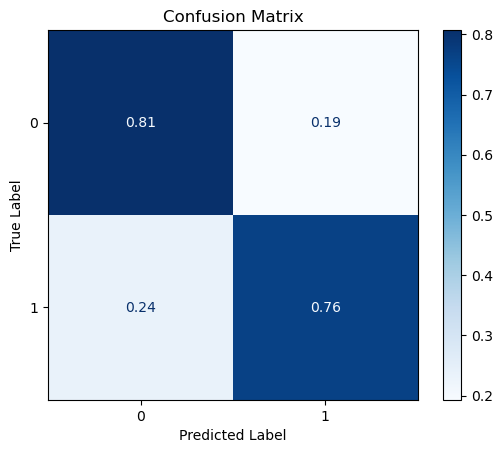

0.5654776370137015

In [19]:
y_pred_proba_bm = pipeline_for_bm.predict_proba(X_test)[:,1]
best_th = evaluate_metrics(y_test=y_test,y_pred=y_pred_proba_bm,normalize='true')
best_th

A versão otimizada conseguiu ser mais balanceada com uma f1-score de 0.66. Pela confusion matrix também vamos que a quantidade de falso positivos e falsos negativos diminuiram.

Com base no modelo em árvore podemos visualizar também a importância das features para definir quem ou não realizou o Churn com base na feature importance.

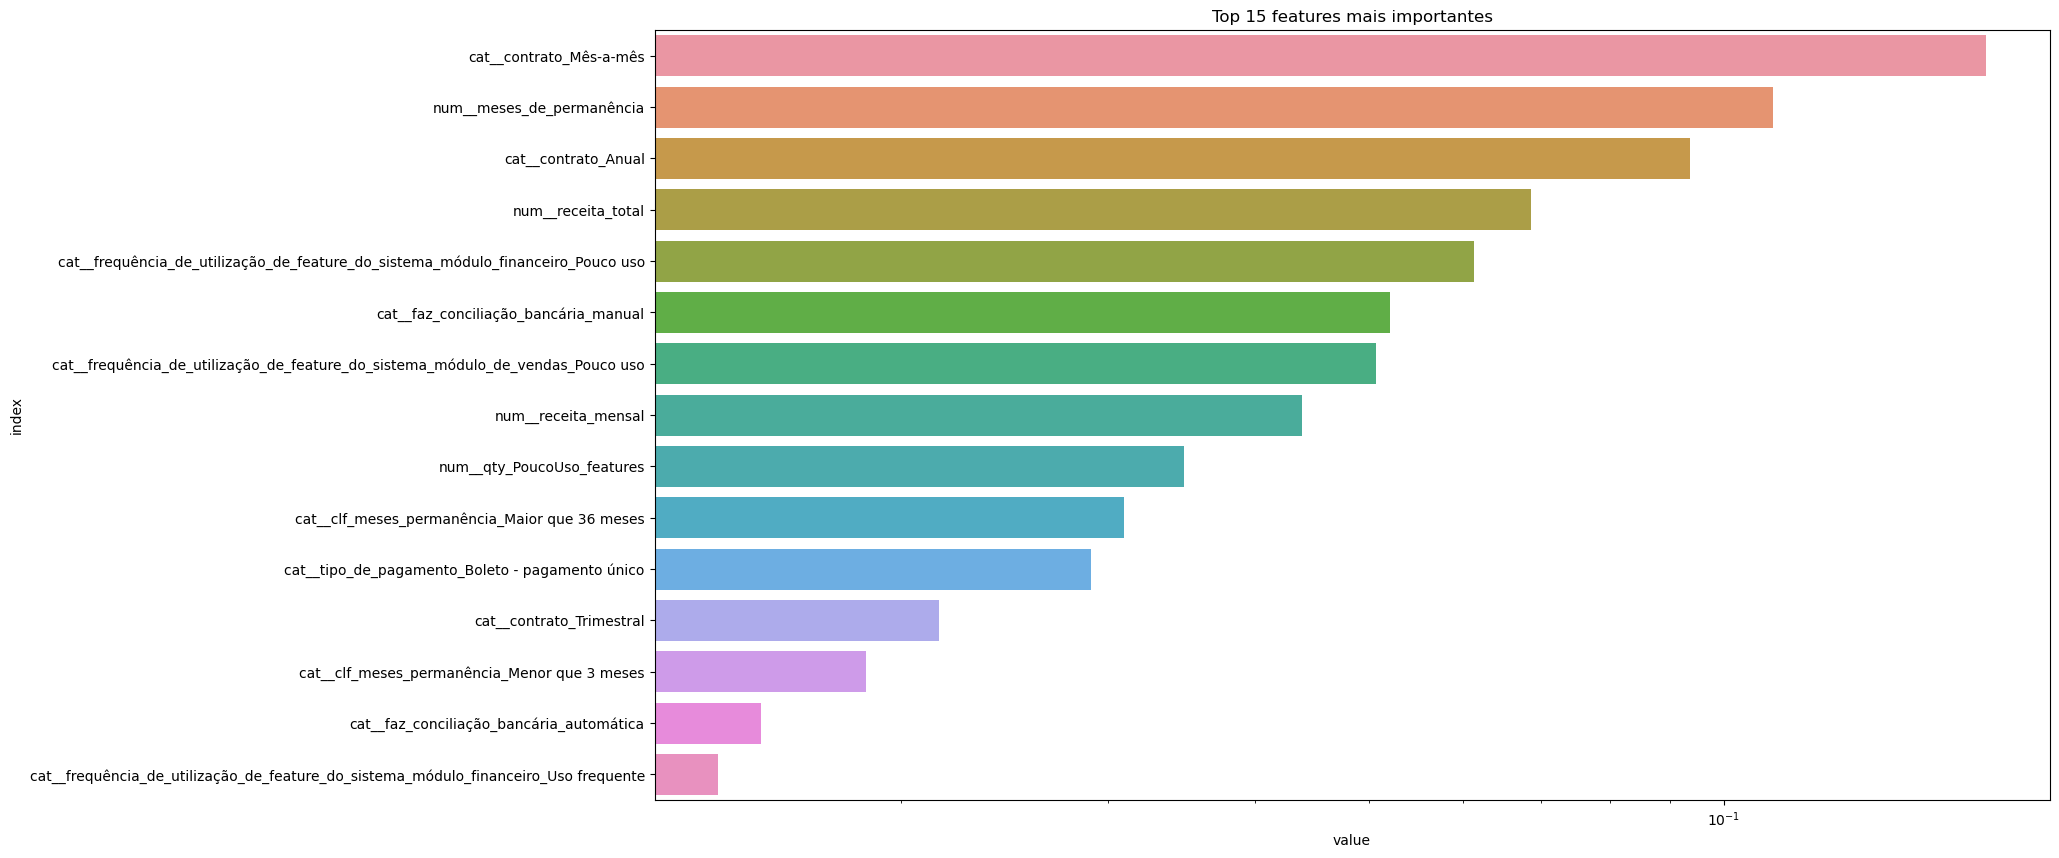

In [22]:
output_feature_names = preprocessor.get_feature_names_out()
best_model_feat_imp = pd.Series(pipeline_for_bm.named_steps.model.feature_importances_,index=output_feature_names)
df_feat_imp_best_model = best_model_feat_imp.reset_index(name="value").sort_values(by="value",ascending=False)


fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(data=df_feat_imp_best_model[:15],y="index",x="value")
ax.set_xscale(value="log")
ax.set_title("Top 15 features mais importantes");

Um ponto positivo das variavéis mais importantes é ver que as variáveis inseridas pela feature engineering são importantes para o modelo principalmente as features `qty_PoucoUso_features` e `clf_meses_permanência`.

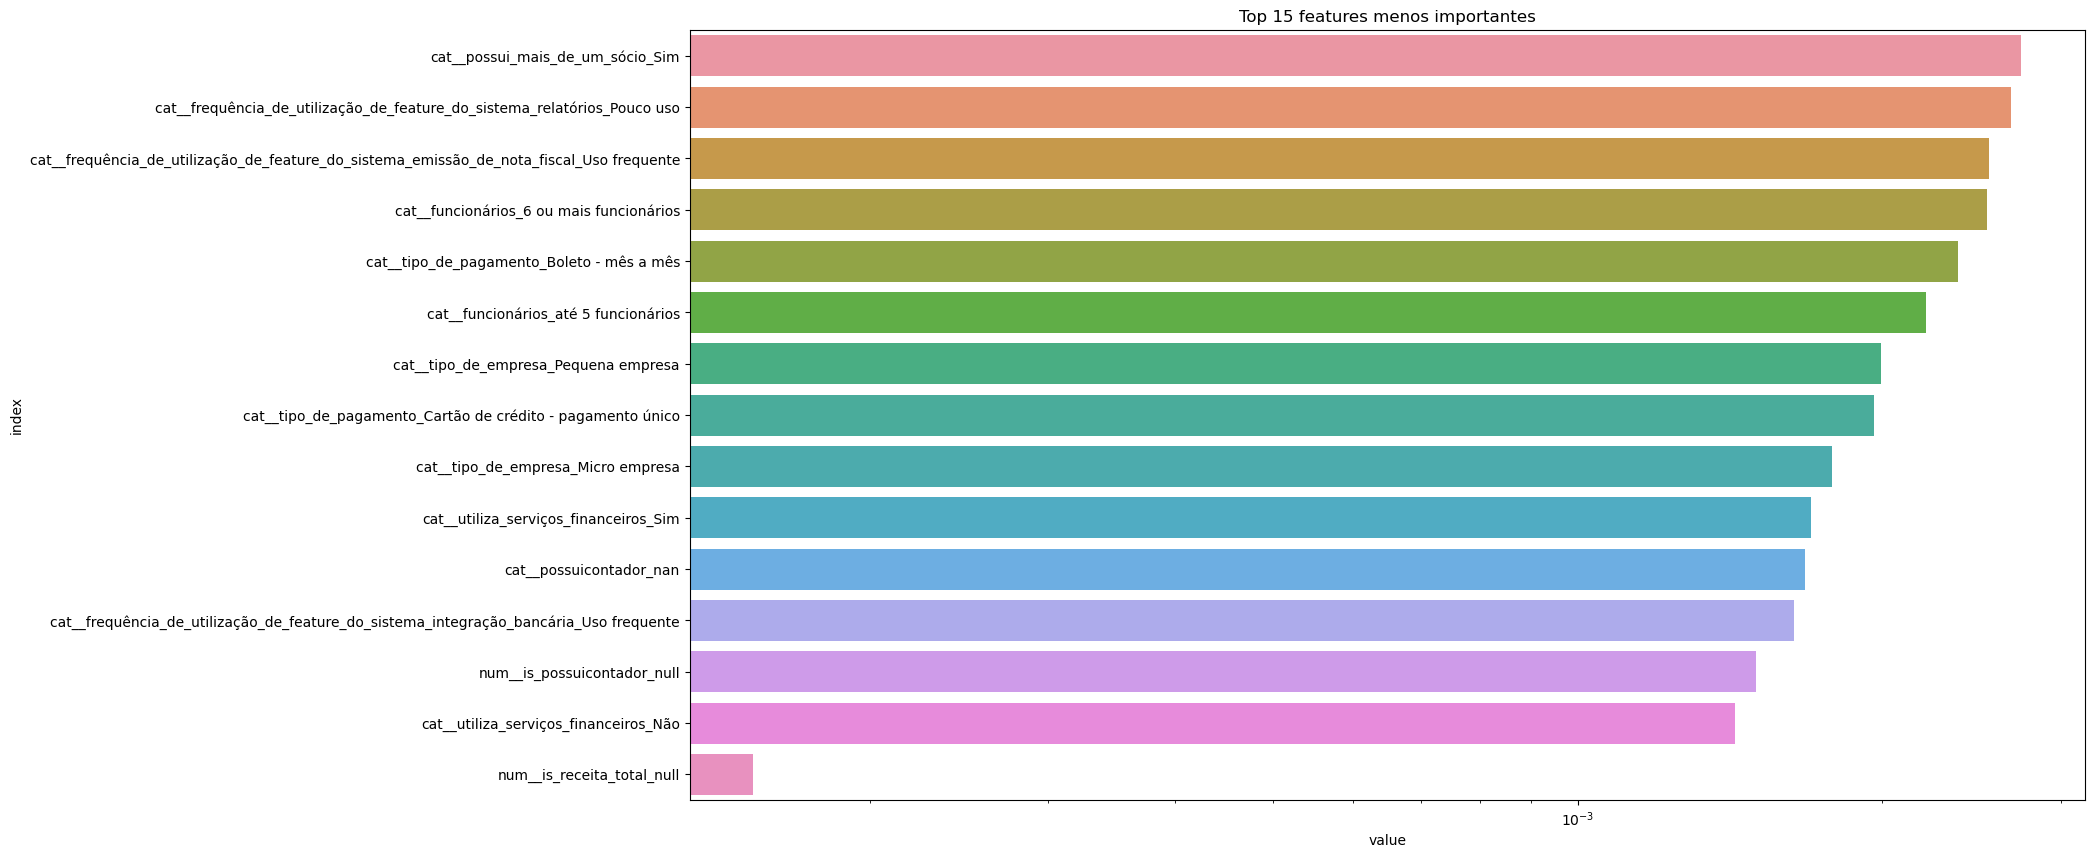

In [24]:
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(data=df_feat_imp_best_model[-15::],y="index",x="value")
ax.set_xscale(value="log")
ax.set_title("Top 15 features menos importantes");

Já para as features menos importantes vemos que as variáveis que indicam missing values são as menos importantes além disso temos uma feature (sistema de integração bancária) que ter seu uso frequente não é tão importante assim como não utilizar serviços financeiros.

## 5 - Feature Selection

Um dos processos importantes para investigação é selecionar as melhores features do modelo através do processo de feature selection. Como estamos com um modelo não linear uma maneira de fazer esse processo é através de Recursive feature elimination (RFE) onde se seleciona as features recursivamente utilizando validação cruzada, cada subset é treinado com um estimador que calcula a importancia das features e recursivamente ele remove as features menos importantes até chegar no mínimo de features necessárias. A performance desses subsets de features é avaliada por uma métrica e o melhor subset é aquele que teve a maior valor para uma métrica definida.

A vantagem de utilizar isso com a RF é calcular a importancia das features utilizando o conceito de ganho de informação das árvores de decisão e escolher as features que mais influenciam no resultado final.

In [41]:
# model with best_params 

model_for_fs = RandomForestClassifier(**model_best_params)

Xt = preprocessor.transform(X_train)

# Apply feature selection
fs = RFECV(
    estimator=model_for_fs,
    step=2,
    min_features_to_select=int(Xt.shape[1]*0.6),
    scoring="roc_auc",
    cv=5,
    importance_getter="feature_importances_"
)
fs.fit(Xt,y_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                       criterion='entropy', max_depth=6,
                                       n_estimators=176, random_state=82),
      importance_getter='feature_importances_', min_features_to_select=31,
      scoring='roc_auc', step=2)

In [42]:
output_feature_names = preprocessor.get_feature_names_out()
print("Quantidade de features de entrada:",Xt.shape[1])
print("Quantidade de features selecionadas:",fs.n_features_)
print("Visualizando ranking das features:")
feat_ranking = pd.Series(fs.ranking_,index=output_feature_names)
feat_ranking.sort_values()

Quantidade de features de entrada: 53
Quantidade de features selecionadas: 41
Visualizando ranking das features:


num__emite_boletos                                                                                     1
cat__clf_meses_permanência_Maior que 36 meses                                                          1
cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Nunca utilizou              1
cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Pouco uso                   1
cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Nunca utilizou                 1
cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Pouco uso                      1
cat__frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas_Nunca utilizou                    1
cat__frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas_Pouco uso                         1
cat__frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas_Uso frequente                     1
cat__frequência_de_utilização_de_feature_do_sistema_rel

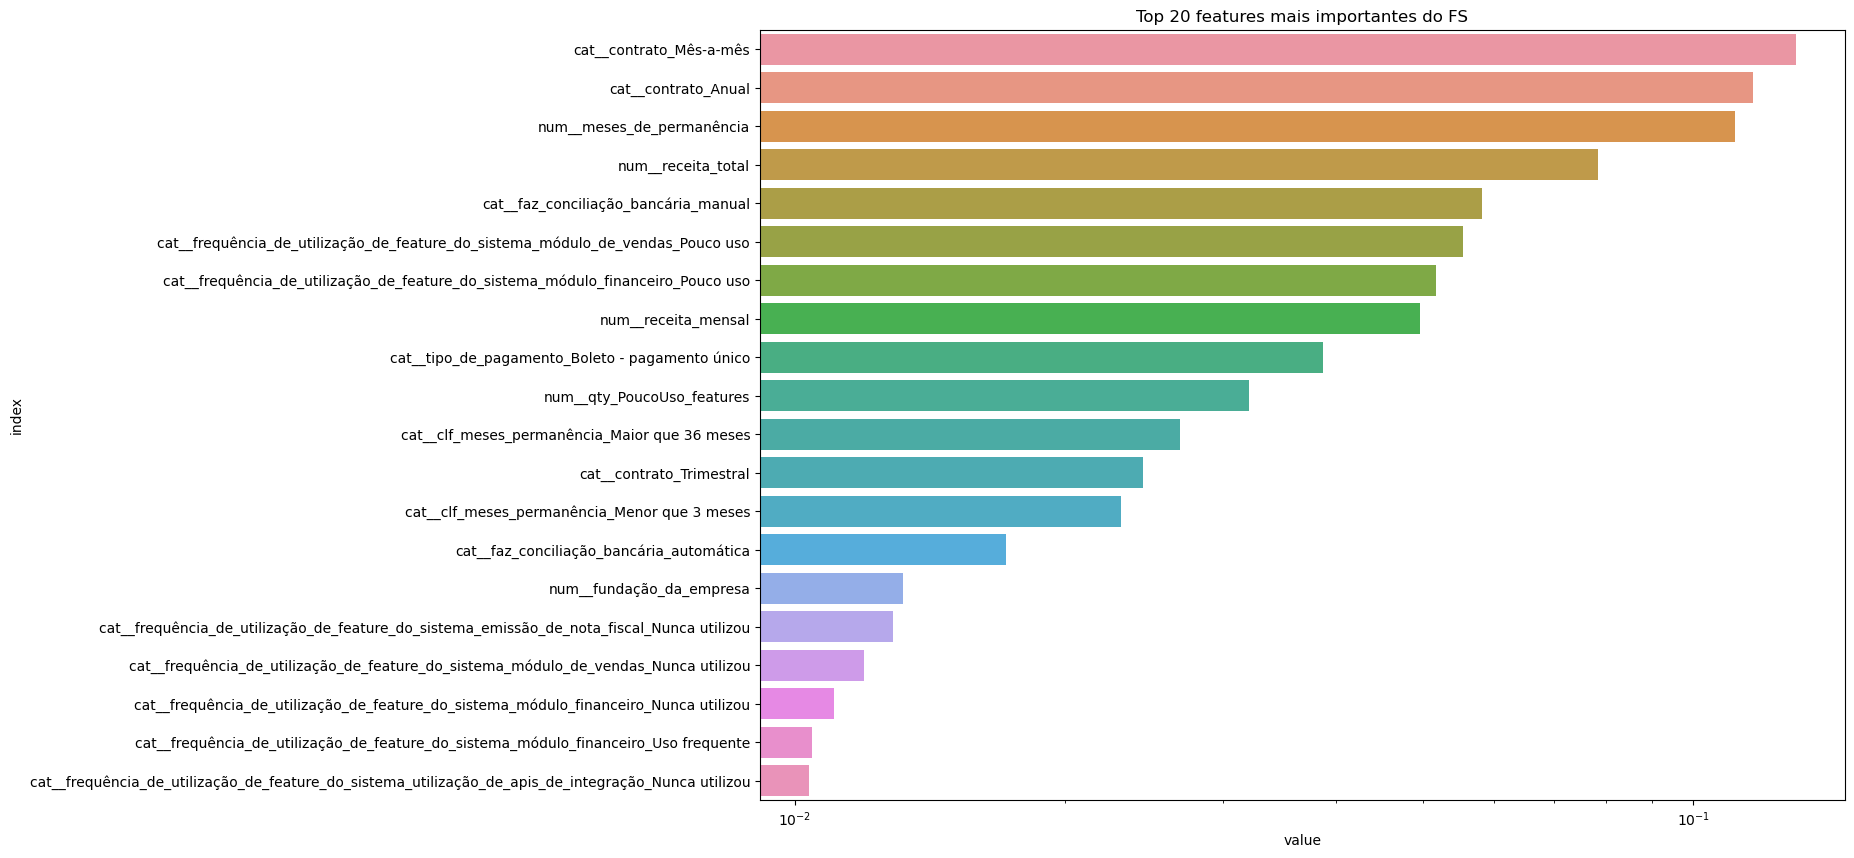

In [45]:
# Verificando importância das features 
fs_feat_impt = pd.Series(fs.estimator_.feature_importances_,index=output_feature_names[fs.support_])
df_fs_feat_impt = fs_feat_impt.reset_index(name="value").sort_values(by="value",ascending=False)

fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(data=df_fs_feat_impt[:20],y="index",x="value")
ax.set_xscale(value="log")
ax.set_title("Top 20 features mais importantes do FS");

In [46]:
print("Features removidas")
rm_feats = set(output_feature_names).difference(set(output_feature_names[fs.support_]))
rm_feats = list(rm_feats)
rm_feats

Features removidas


['cat__utiliza_serviços_financeiros_Sim',
 'cat__utiliza_serviços_financeiros_Não',
 'cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Uso frequente',
 'cat__tipo_de_empresa_Pequena empresa',
 'num__is_possuicontador_null',
 'cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Uso frequente',
 'cat__possui_mais_de_um_sócio_Sim',
 'num__is_receita_total_null',
 'cat__possuicontador_nan',
 'cat__tipo_de_empresa_Micro empresa',
 'cat__tipo_de_pagamento_Cartão de crédito - pagamento único',
 'cat__tipo_de_pagamento_Boleto - mês a mês']

In [43]:
# Avaliando mudança geral 

arr_selected_features = fs.support_

preprocessor_for_fs = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES),
        ],
)

col_selector = ColumnTransformer(
    transformers=[("select_cols","passthrough",arr_selected_features)]
)

pipeline_with_fs = Pipeline(steps=[
    ("column_transformations",preprocessor_for_fs),
    ("select_fs_columns",col_selector),
    ("model",RandomForestClassifier(**model_best_params))
])
pipeline_with_fs.fit(X_train,y_train)

Pipeline(steps=[('column_transformations',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['emite_boletos',
                                                   'fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'qty_PoucoUso_features',
                                                   'is_possuicontador_null',
                                                   'is_receita_total_null',
                                                   'qty_usofrequente',
                                                   'is_receita_mensal_maior_ou_igual_70']),
                                                 ('cat', On...
        True, False, False,  True, False,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=6,
                                        n_estimators=176, random_state=82))])

Precision-Recall AUC: 0.689359509057925
classification_report
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1036
           1       0.60      0.75      0.67       373

    accuracy                           0.80      1409
   macro avg       0.75      0.79      0.77      1409
weighted avg       0.82      0.80      0.81      1409


Best F1-score: 0.6722288438617401 at threshold 0.5737416749214252


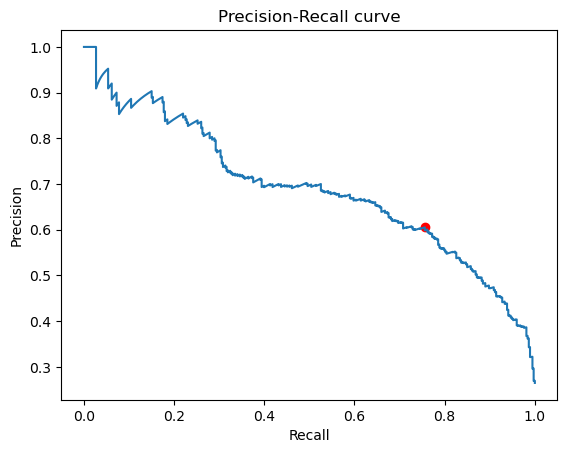

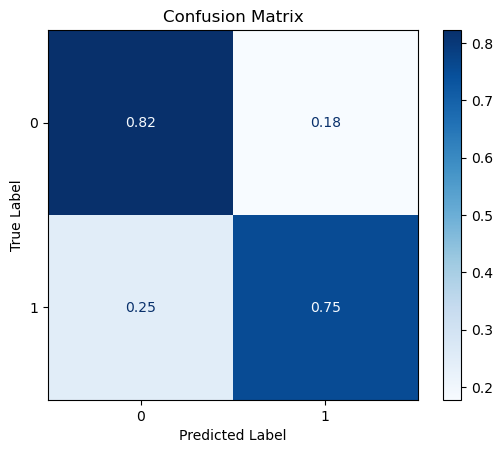

0.5737416749214252

In [44]:
y_pred_proba_fs = pipeline_with_fs.predict_proba(X_test)[:,1]

evaluate_metrics(y_test=y_test,y_pred=y_pred_proba_fs,normalize='true')

Um ponto interessante do feature selection é que ele conseguiu ter um resultado bem próximo ao do modelo otimizado com 12 features a menos e com f1-score um pouco maior. Com base nisso, é possível remover as features com menos importância com segurança, já que elas conseguem prever menos falso negativos e manter uma quantidade de acertos de previsão de churn. Além disso, pelo gráfico e rank de importância vimos também que as features (`cat__utiliza_serviços_financeiros_Sim`, `cat__utiliza_serviços_financeiros_Não`,`cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Uso frequente`,`cat__tipo_de_empresa_Pequena empresa`,`num__is_possuicontador_null`, `cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Uso frequente`,`cat__possui_mais_de_um_sócio_Sim`,`num__is_receita_total_null`,`cat__possuicontador_nan`,`cat__tipo_de_empresa_Micro empresa`,`cat__tipo_de_pagamento_Cartão de crédito - pagamento único`,`cat__tipo_de_pagamento_Boleto - mês a mês`) tem um valor de importância bem abaixo das outras features, ou seja, elas realmente não agregam tanta informação ao modelo.

Logo, o modelo final terá mais um processo da pipeline que é selecionar as features mais importantes para a predição.

## 6 - Save best model

In [47]:
OUTPUT_PATH = Path("./config")

num_features = [str.encode(col,encoding="ISO-8859-1") for col in NUM_FEATURES]
cat_features = [str.encode(col,encoding="ISO-8859-1") for col in CAT_FEATURES]
select_cols_arr = fs.support_.tolist()

MODEL_PARAMETERS = {
    "model_name":"random_forest_clf_for_churn",
    "model_version":1,
    "model_parameters":{
        "fit_params":model_best_params,
        "fs_params": {"select_cols_arr":select_cols_arr},
        "predict_params":{"decision_threshold":float(best_th)}},
    "model_features":{"NUM_FEATURES":num_features,"CAT_FEATURES":cat_features},
    "model_target":"churn"
}


if OUTPUT_PATH.is_dir():
    with open(f"{OUTPUT_PATH}/model_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)
else:
    OUTPUT_PATH.mkdir(exist_ok=True,parents=True)
    with open(f"{OUTPUT_PATH}/model_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)

## 7 - Conclusão

- A random forest conseguiu criar um modelo melhor que os baselines principalmente em relação a f1-score. O modelo otimizado conseguiu ter um valor de 0.66 contra 0.51 da decision tree e 0.31 do modelo heuritisco. 
- Podemos concluir que as features construídas que se referem ao tempo de permanência e utilização das features são importantes para decisão 
final.
- O processo de seleção de features (RFCV) conseguiu ter um modelo um pouco mais otimizado também removendo as features menos relevantes para o modelo (`cat__utiliza_serviços_financeiros_Sim`, `cat__utiliza_serviços_financeiros_Não`,`cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Uso frequente`,`cat__tipo_de_empresa_Pequena empresa`,`num__is_possuicontador_null`, `cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Uso frequente`,`cat__possui_mais_de_um_sócio_Sim`,`num__is_receita_total_null`,`cat__possuicontador_nan`,`cat__tipo_de_empresa_Micro empresa`,`cat__tipo_de_pagamento_Cartão de crédito - pagamento único`,`cat__tipo_de_pagamento_Boleto - mês a mês` ). Isso significou uma redução de 22% do modelo e ganho na f1-score de 1.5% e 1.7% de precision e redução de 1.3% no recall.
- Como modelo final vamos apenas usar as features selecionadas pelo RFCV junto com os melhores parametros encontrados. As configurações estão em `.\config\config_model.yaml`.